<a href="https://colab.research.google.com/github/haminhtien99/object_detection_using_UAV/blob/main/detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Test with images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download images from web

In [ ]:
%cd /content/drive/MyDrive/mipt/Nir/yolov7_train/yolov7/test_images
!wget https://github.com/jwangjie/UAV-Vehicle-Detection-Dataset/blob/master/dataset3/img000757.jpg


detection

In [29]:
%cd /content/drive/MyDrive/mipt/Nir/yolov7_train/yolov7/
!python detect.py --weights /content/drive/MyDrive/mipt/Nir/yolov7_train/yolov7/runs/train/exp32/weights/best.pt --source /content/drive/MyDrive/mipt/Nir/yolov7_train/yolov7/test_images/test.jpg

/content/drive/MyDrive/mipt/Nir/yolov7_train/yolov7
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/content/drive/MyDrive/mipt/Nir/yolov7_train/yolov7/test_images/test.jpg', update=False, view_img=False, weights=['/content/drive/MyDrive/mipt/Nir/yolov7_train/yolov7/runs/train/exp32/weights/best.pt'])
YOLOR 🚀 v0.1-116-g8c0bf3f torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15109.875MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (

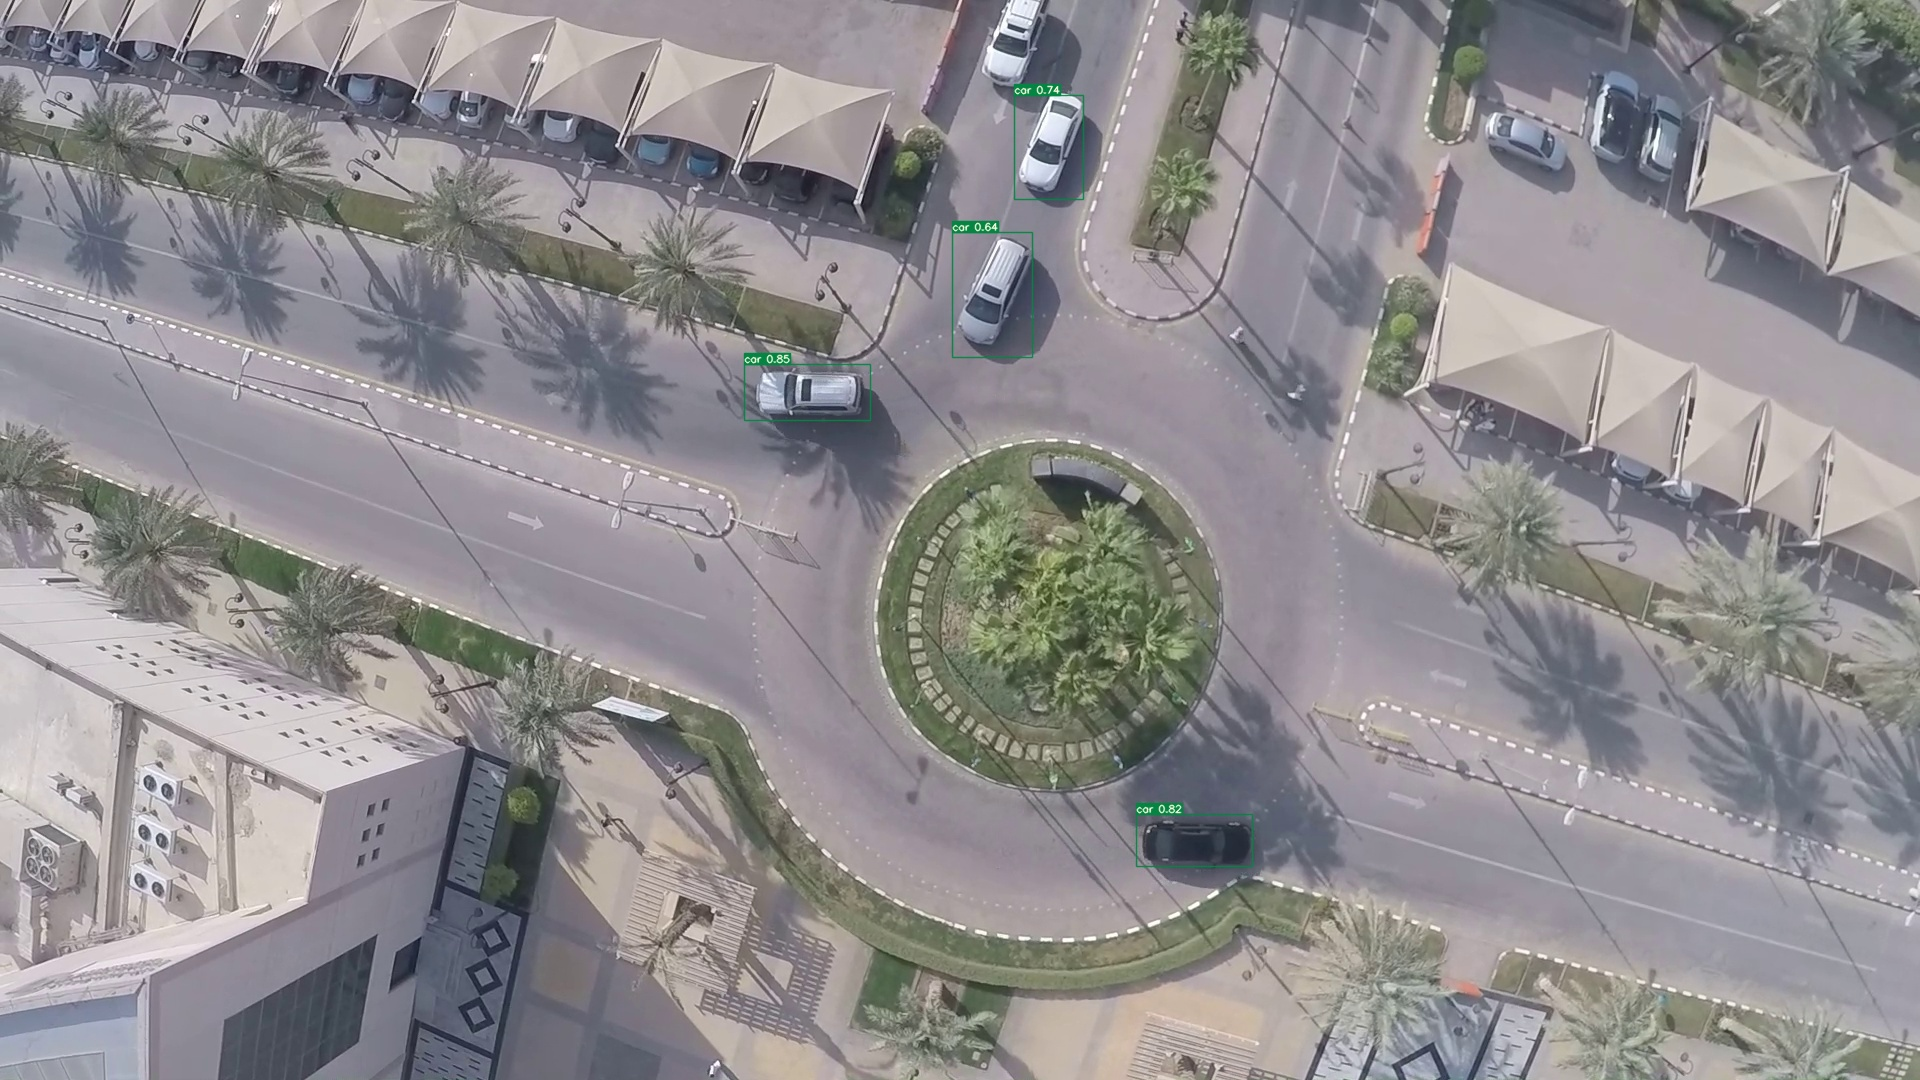

In [30]:
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/mipt/Nir/yolov7_train/yolov7/runs/detect/exp4/test.jpg"))

Script for detection

In [31]:
import os
import sys
sys.path.append('/content/drive/MyDrive/mipt/Nir/yolov7_train/yolov7')


import argparse
import time
from pathlib import Path
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [32]:
classes_to_filter = None  #You can give list of classes to filter by name, Be happy you don't have to put class number. ['train','person' ]
source_image_path = "/content/drive/MyDrive/mipt/Nir/yolov7_train/yolov7/test_images/harlem-0187.jpg"

opt  = {
    
    "weights": "/content/drive/MyDrive/mipt/Nir/yolov7_train/yolov7/runs/train/exp32/weights/best.pt", # Path to weights file default weights are for nano model
    "yaml"   : "/content/drive/MyDrive/mipt/Nir/yolov7_train/yolov7/data/mydataset.yaml",
    "img-size": 640, # default image size
    "conf-thres": 0.1, # confidence threshold for inference.
    "iou-thres" : 0.45, # NMS IoU threshold for inference.
    "device" : '0',  # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "classes" : classes_to_filter  # list of classes to filter or None

}

In [33]:
with torch.no_grad():
  weights, imgsz = opt['weights'], opt['img-size']
  set_logging()
  device = select_device(opt['device'])
  half = device.type != 'cpu'
  model = attempt_load(weights, map_location=device)  # load FP32 model
  stride = int(model.stride.max())  # model stride
  imgsz = check_img_size(imgsz, s=stride)  # check img_size
  if half:
    model.half()

  names = model.module.names if hasattr(model, 'module') else model.names
  colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
  if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

  img0 = cv2.imread(source_image_path)
  img = letterbox(img0, imgsz, stride=stride)[0]
  img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
  img = np.ascontiguousarray(img)
  img = torch.from_numpy(img).to(device)
  img = img.half() if half else img.float()  # uint8 to fp16/32
  img /= 255.0  # 0 - 255 to 0.0 - 1.0
  if img.ndimension() == 3:
    img = img.unsqueeze(0)

  # Inference
  t1 = time_synchronized()
  pred = model(img, augment= False)[0]

  # Apply NMS
  classes = None
  if opt['classes']:
    classes = []
    for class_name in opt['classes']:

      classes.append(opt['classes'].index(class_name))


  pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
  t2 = time_synchronized()
  for i, det in enumerate(pred):
    s = ''
    s += '%gx%g ' % img.shape[2:]  # print string
    gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
    if len(det):
      det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

      for c in det[:, -1].unique():
        n = (det[:, -1] == c).sum()  # detections per class
        s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
    
      for *xyxy, conf, cls in reversed(det):

        label = f'{names[int(cls)]} {conf:.2f}'
        plot_one_box(xyxy, img0, label=label, color=colors[int(cls)], line_thickness=3)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


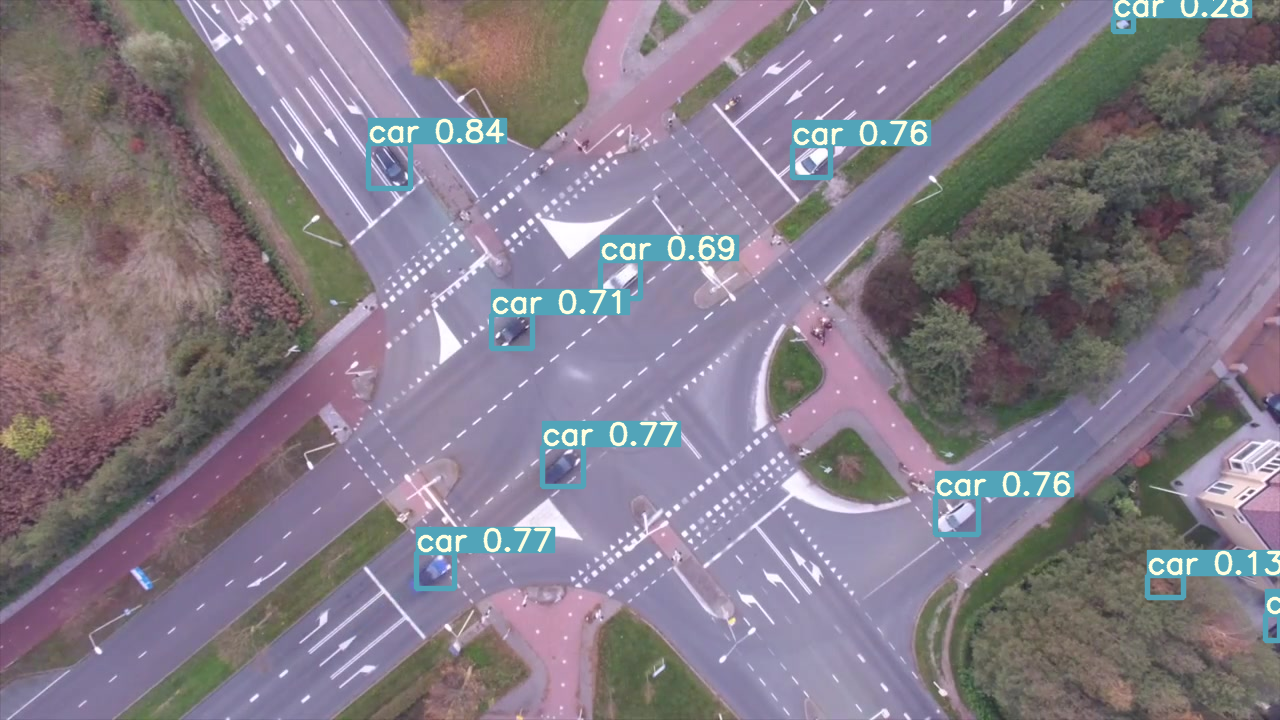

In [34]:
from google.colab.patches import cv2_imshow
cv2_imshow(img0)